In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [75]:
df = pd.read_excel('sample_data.xlsx')

In [76]:
df.head()

,name,fiscal_quarter_sales,_C1
0,abc,FY2018Q1,216244.2
1,abc,FY2018Q4,211703.5
2,abc,FY2019Q2,57665.3
3,abc,FY2020Q2,1540760.0
4,abc,FY2020Q3,2480169.0


In [77]:
df.shape

(52, 3)

### Check for the null values

In [78]:
df.isnull().sum().any()

False

### rename the column name

In [79]:
df = df.rename(columns = {'_C1': 'revenue'})
df.head()

,name,fiscal_quarter_sales,revenue
0,abc,FY2018Q1,216244.2
1,abc,FY2018Q4,211703.5
2,abc,FY2019Q2,57665.3
3,abc,FY2020Q2,1540760.0
4,abc,FY2020Q3,2480169.0


### Let's convert fiscal quarter sales to dates

In [80]:
def make_dates(df, datecol):
    df['fyyear'] = df[datecol].str.split('Q', 0, expand = True)[0]
    df['year'] = df['fyyear'].str.split('Y', 0, expand = True)[1]
    df['quarter'] = df[datecol].str.split('Q', 0, expand = True)[1]
    df.drop('fyyear', axis = 1, inplace = True)
    df['fyqtr'] = df[datecol].str.split('Y', 0, expand = True)[1]
    return df

In [81]:
df = make_dates(df, 'fiscal_quarter_sales')

In [82]:
df.head()

,name,fiscal_quarter_sales,revenue,year,quarter,fyqtr
0,abc,FY2018Q1,216244.2,2018,1,2018Q1
1,abc,FY2018Q4,211703.5,2018,4,2018Q4
2,abc,FY2019Q2,57665.3,2019,2,2019Q2
3,abc,FY2020Q2,1540760.0,2020,2,2020Q2
4,abc,FY2020Q3,2480169.0,2020,3,2020Q3


### sort values by year and quarter

In [83]:
df.sort_values(by = ['year', 'quarter'], inplace = True)

### Look at unique names values

In [84]:
df.name.unique()

array(['abd', 'abe', 'abc'], dtype=object)

### Make a list of names to genertae plots further

In [85]:
plotorder = df.name.unique().tolist()
plotorder

['abd', 'abe', 'abc']

### Let's genertae the plot of time series for raw dataset

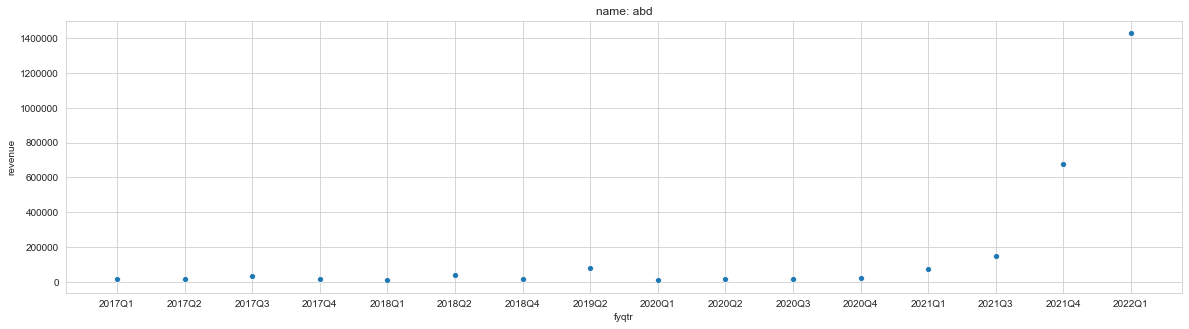

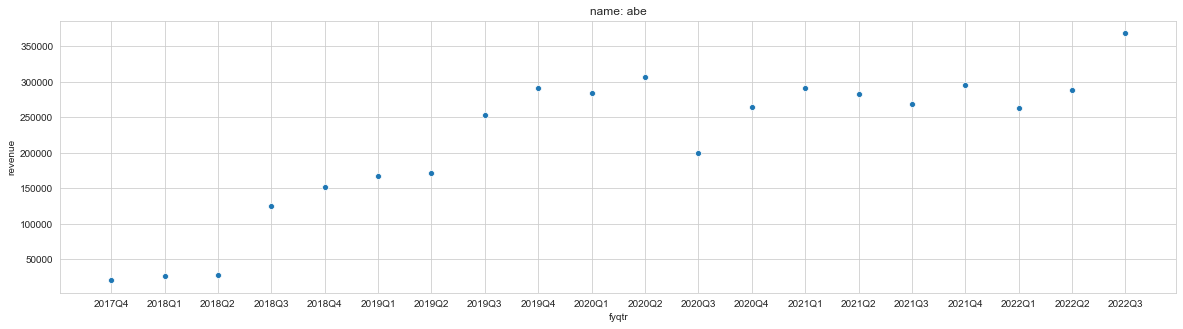

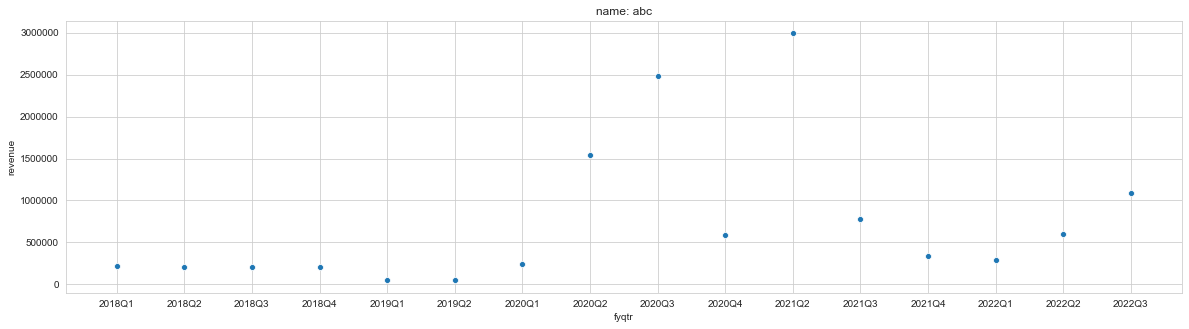

In [17]:
for part in plotorder:
    data = df[df.name == part]
    data.index = pd.DatetimeIndex(data.fyqtr.str.lower())
    plt.figure(figsize = (20,5))
    sns.scatterplot(x = 'fyqtr', y = 'revenue', data = data)
    plt.title('name: ' + part)
    plt.show()

### Implementing Linear Regression to detect the trend over various quarters

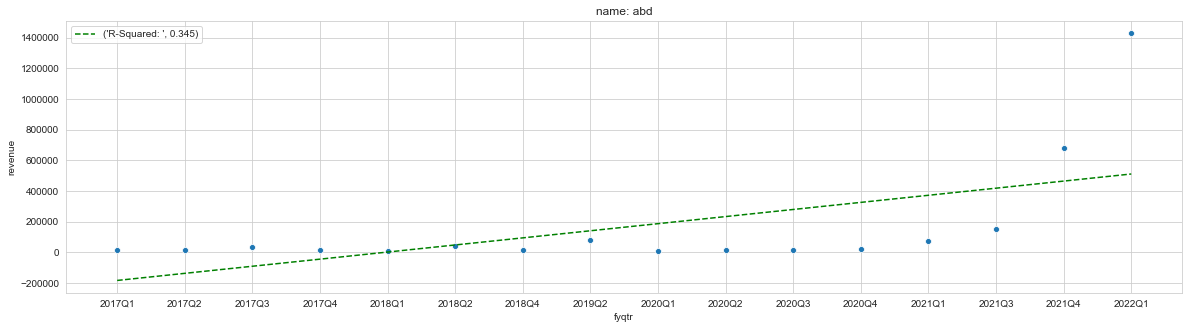

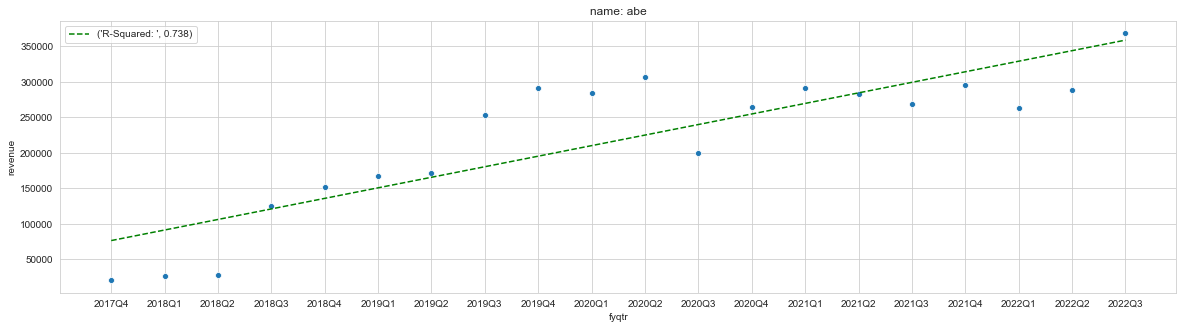

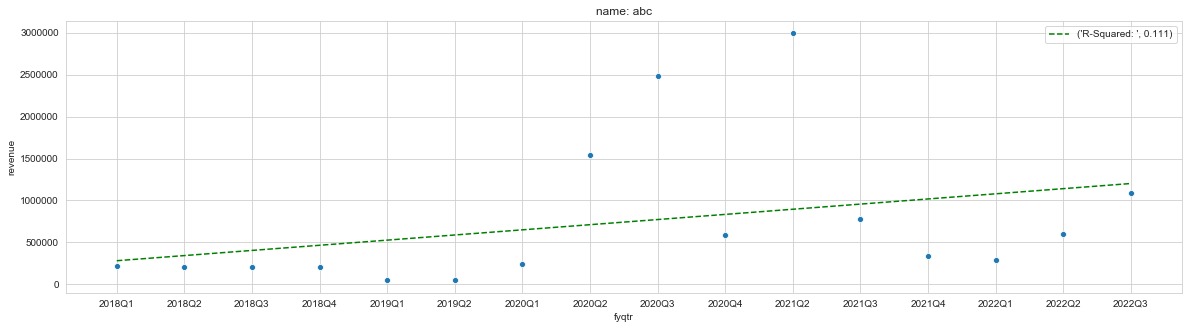

In [30]:
import scipy
for part in plotorder:
    data = df[df.name == part]
    data.index = pd.DatetimeIndex(data.fyqtr.str.lower())
    plt.figure(figsize = (20,5))
    sns.scatterplot(x = 'fyqtr', y = 'revenue', data = data)
    
    ### Trend line for plotting
    x = [i for i in range(data.revenue.values.shape[0])]
    y = data.revenue.values[-len(x):]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    plt.plot(x, p(x), "g--", label = ('R-Squared: ', round(r_value**2, 3)))
    
    plt.title('name: ' + part)
    plt.legend()
    plt.show()

### Implemeting SMA

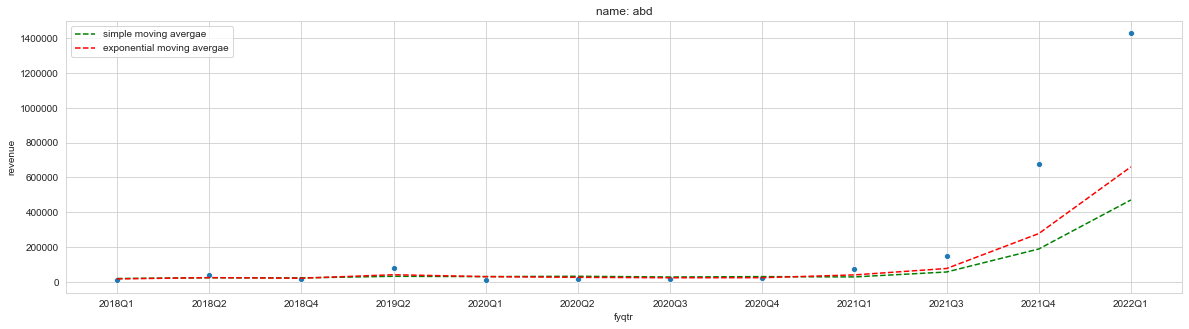

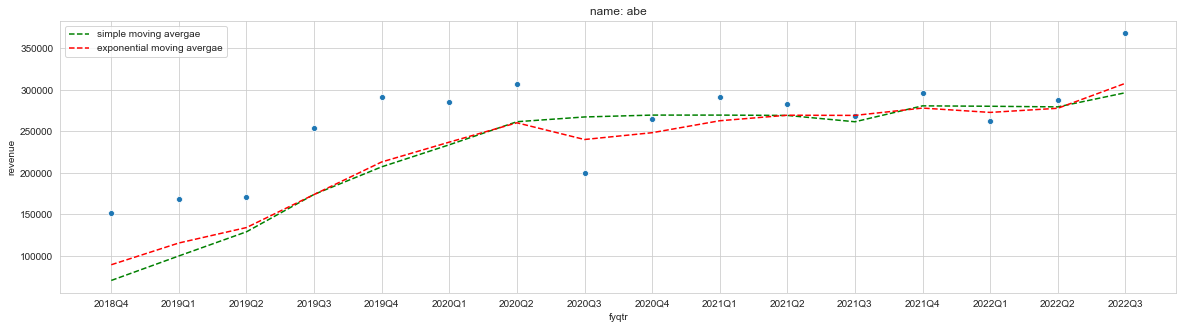

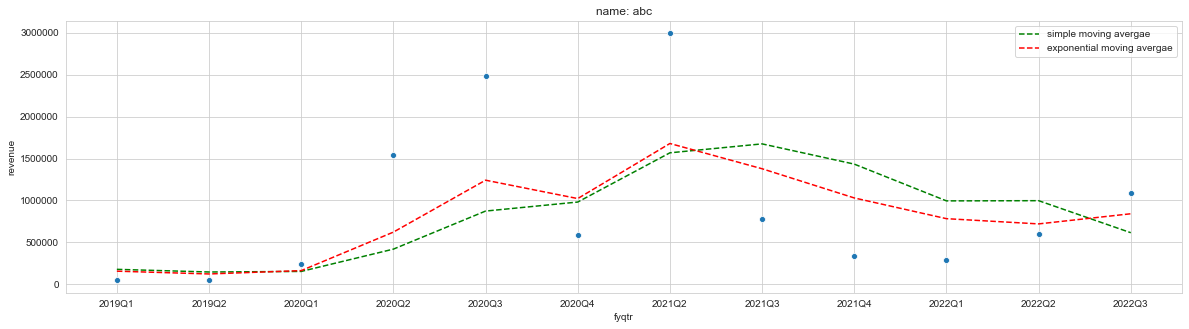

In [31]:
for part in plotorder:
    data = df[df.name == part]
    data.index = pd.DatetimeIndex(data.fyqtr.str.lower())
    ### calculate moving avergaes
    data['SMA'] = data['revenue'].rolling(window = 5).mean()
    data['EMA'] = data['revenue'].ewm(span=5, adjust = False).mean()
    ### drop nan values (for better visualization of SMA, can try without dropping nan values also)
    data.dropna(inplace = True)
    plt.figure(figsize = (20,5))
    sns.scatterplot(x = 'fyqtr', y = 'revenue', data = data)
    ### Trend line for plotting
    x = [i for i in range(data.revenue.values.shape[0])]
    plt.plot(x, data['SMA'], 'g--', label = 'simple moving avergae')
    plt.plot(x, data['EMA'], 'r--', label = 'exponential moving avergae')
    plt.title('name: ' + part)
    plt.legend()
    plt.show()

In [43]:
from plotly.subplots import make_subplots
import plotly.graph_objs as go
for part in plotorder:
    data = df[df.name == part]
    data.index = pd.DatetimeIndex(data.fyqtr.str.lower())
    ### calculate MACD
    k = data['revenue'].ewm(span=5, adjust = False, min_periods =5).mean()
    d = data['revenue'].ewm(span=3, adjust = False, min_periods = 3).mean()
    macd = d-k
    ### Get the 2-day EMA of the MACD for the signal line
    macd_s = macd.ewm(span=3, adjust = False, min_periods = 3).mean()
    ### To plot histogram
    macd_h = macd - macd_s
    
    data['macd'] = data.index.map(macd)
    data['macd_h'] = data.index.map(macd_h)
    data['macd_s'] = data.index.map(macd_s)
    pd.set_option("display.max_columns", None)
    
    data.columns = [x.lower() for x in data.columns]
    fig = make_subplots(rows=2, cols =1)
    fig.append_trace(
        go.Scatter(
            x = data.index,
            y = data['revenue'],
            line = dict(color = 'red', width =1),
            name = 'original data:' +" "+ part,
            legendgroup = '1'),
            row = 1, col =1)
    
    ### fast signal line
    fig.append_trace(
    go.Scatter(
        x = data.index,
        y = data['macd'],
        line = dict(color = '#ff9900', width =2),
        name = 'macd',
        legendgroup = '2'),
        row = 2, col =1)
    ### slow signal line
    fig.append_trace(
    go.Scatter(
        x = data.index,
        y = data['macd_s'],
        line = dict(color = 'black', width =2),
        name = 'signal',
        legendgroup = '2'),
        row = 2, col =1)
    ### Histogram
    colors = np.where(data['macd_h'] < 0, '#000', '#ff9900')
    fig.append_trace(
    go.Bar(
        x = data.index,
        y = data['macd_h'],
        name = 'histogram',
        marker_color = colors,
        ),
        row = 2, col =1)
#     plt.title('name: ' + part)
#     plt.legend()
    fig.show()

In [44]:
from patsy import cr

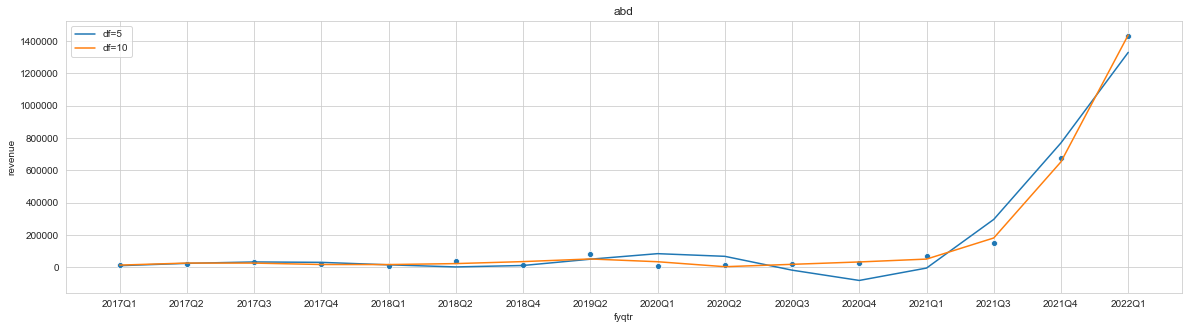

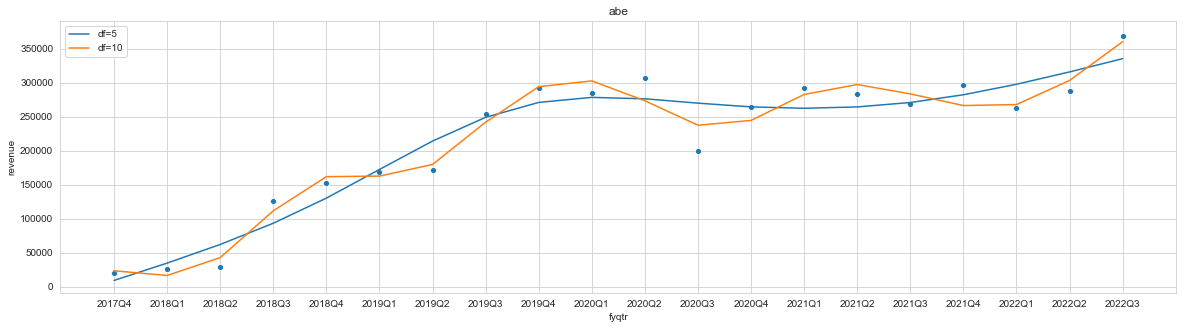

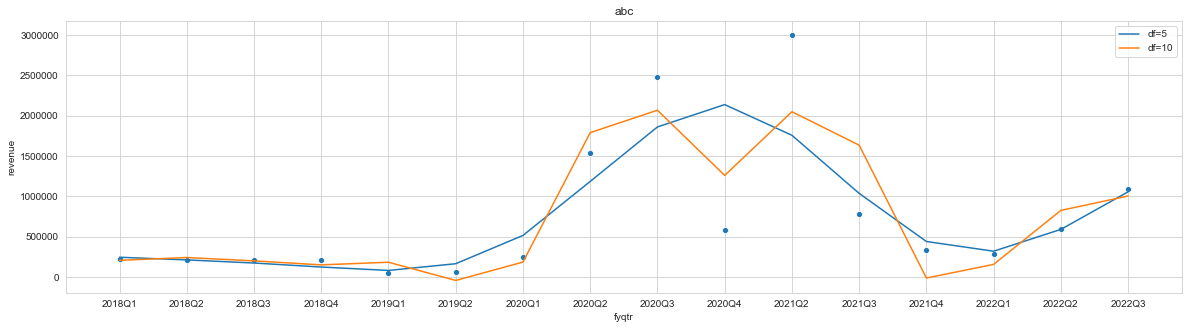

In [87]:
def plot_smooth(d=5):
    x_base = cr(x, df=d, constraints ='center')
    model = LinearRegression().fit(x_base, y)
    y_hat = model.predict(x_base)
    plt.plot(x, y_hat, label = f"df={d}")
    
for part in plotorder:
    data = df[df.name == part]
    data.index = pd.DatetimeIndex(data.fyqtr.str.lower())
    x = [i for i in range(data.revenue.shape[0])]
    y = data.revenue.values[-len(x):]
    plt.figure(figsize=(20,5))
    for d in (5, 10):
        plot_smooth(d)
    sns.scatterplot(x = 'fyqtr', y = 'revenue', data=data)
    plt.title(part)
    plt.legend()
    plt.show()